In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from utils import draw_in_row
from utils import NormalDistribution
from utils import plot_confusion_matrix
from utils import MixtureGaussians

plt.rcParams['figure.figsize'] = (12,6)

np.random.seed(42)

# Bayes optimal during training and deployment phases

Imagine a toy example where we have two known classes to classify $y_1$ and $y_2$; lemons and oranges respectively.
And we only get their relative size $x$ with respect to the same common unit $1$.

- Classes
 - $y_1$: lemon
 - $y_2$: orange
- Feature
 - $x$: relative size to the same unit value
 
 In this case, we know the real probability distributions for both classes, consequently we do not need to estimate them. Their distributions come from two different Gaussians $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$. And they both have different priors $p(y_1)$ and $p(y_2)$ respectively.

In [2]:
norm_y1 = NormalDistribution(mu=0.9, sigma=0.2)
norm_y2 = NormalDistribution(mu=1.1, sigma=0.3)

p_y1 = 0.4
p_y2 = 0.6

Lets visualize a small sample with both classes.

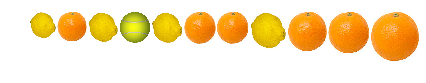

In [3]:
n_samples = 10

x = np.hstack((norm_y1.sample(int(p_y1*n_samples)), norm_y2.sample(int(p_y2*n_samples))))
y = np.hstack((['lemon']*int(p_y1*n_samples), ['orange']*int(p_y2*n_samples)))

draw_in_row(y, x)

And lets see their respective probability density function.

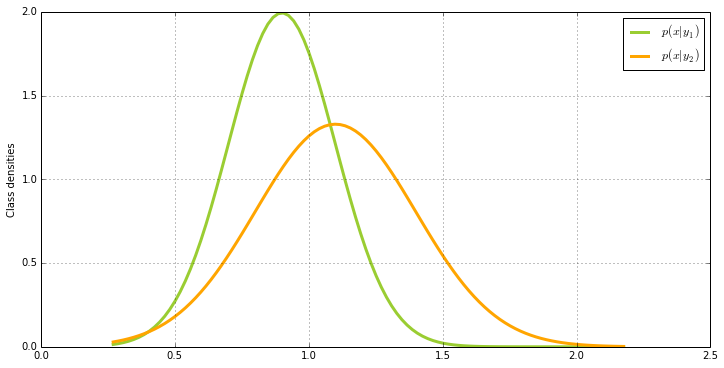

In [4]:
x_lin = np.linspace(x.min()-3*x.std(), x.max()+3*x.std(), 100)

p_x_g_y1 = norm_y1.pdf(x_lin)
p_x_g_y2 = norm_y2.pdf(x_lin)

plt.plot(x_lin, p_x_g_y1, color='yellowgreen', label='$p(x|y_1)$', linewidth=3)
plt.plot(x_lin, p_x_g_y2, color='orange', label='$p(x|y_2)$', linewidth=3)
plt.ylabel('Class densities')
plt.legend()
plt.grid(True)

## Posterior probabilities (Bayes' rule)

Now, with their densities and their prior probabilities we can use Baye's rule to compute their posterior probabilities.

$$
    p(Y=y_i|X=x) = \frac{p(Y=y_i,X=x)}{p(X=x)} = \frac{p(X=x|Y=y_i)*p(Y=y_i)}{p(X=x)}
$$

If we assume that these are the only classes we can compute $p(X=x)$ with:

$$
    p(X=x) = \sum_{i \in \{1,\dots , k} p(X=x,Y=y_i) = \sum_{i \in \{1,\dots , k} p(X=x|Y=y_i)p(Y=y_i)
$$

Then, we can visualize what are these probabilities given the feature $x$.

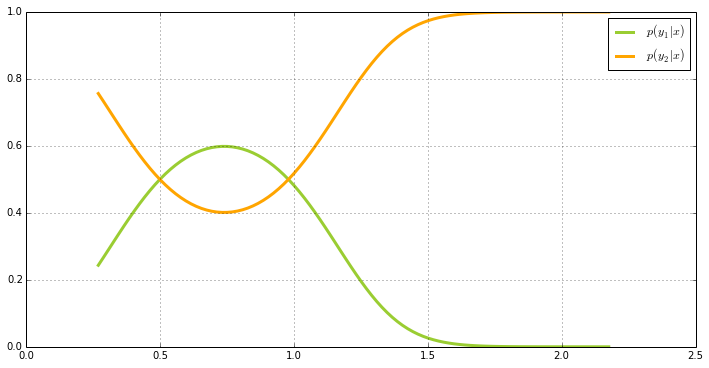

In [5]:
p_x = p_x_g_y1*p_y1 + p_x_g_y2*p_y2

p_y1_g_x = (p_x_g_y1*p_y1)/p_x
p_y2_g_x = (p_x_g_y2*p_y2)/p_x

plt.plot(x_lin, p_y1_g_x, color='yellowgreen', label='$p(y_1|x)$', linewidth=3)
plt.plot(x_lin, p_y2_g_x, color='orange', label='$p(y_2|x)$', linewidth=3)
plt.legend()
plt.grid(True)

## Error for a larger sample

The posterior probabilities are the optimal bayes in this case. This means that if we know the real distributions for both classes, then for a given sample, predicting these posterior probabilities minimize the log-loss error and the accuracy.

Then, we can test the error that is not possible to reduce because of the variance of the distributions.

We can create a larger sample from the same distributions:

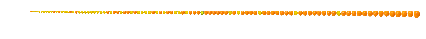

In [6]:
n_samples = 100

x = np.hstack((norm_y1.sample(int(p_y1*n_samples)), norm_y2.sample(int(p_y2*n_samples))))
y = np.hstack((['lemon']*int(p_y1*n_samples), ['orange']*int(p_y2*n_samples)))

draw_in_row(y, x)

And then, we can see compare with the predictions from the Bayes optimal.

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


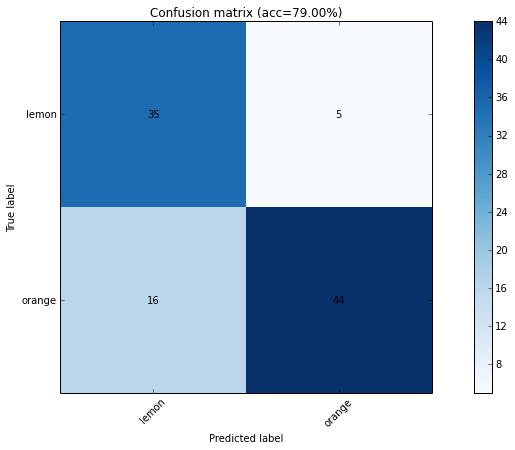

In [7]:
q_x_g_y1 = norm_y1.pdf(x)
q_x_g_y2 = norm_y2.pdf(x)
q_x = q_x_g_y1*p_y1 + q_x_g_y2*p_y2

q_y1_g_x = q_x_g_y1*p_y1/q_x
q_y2_g_x = q_x_g_y2*p_y2/q_x

q_y_g_x = np.vstack((q_y1_g_x, q_y2_g_x))
labels = np.array(['lemon', 'orange'])
y_pred = labels[q_y_g_x.argmax(axis=0)]

cm = confusion_matrix(y, y_pred, labels=labels)
plot_confusion_matrix(cm, labels=labels)

It is not possible to reduce this error as it comes from an intrinsic ambiguity.

## Deployment time

However, how can we be sure that during deployment the only objects that will need to be classified
will come from these two classes? We will refer to these known classes as the _foreground_. If for the training of any given model the classes that do not belong to the _foreground_ are removed manually, then during deployment we should ensure that only the _foreground_ classes apear. If that can not be ensured, the performance of the optimal bayes will not be optimal anymore.

In this example, lets assume that there are two new classes that were not considered before.
We can see a small sample and their respective probability density functions.

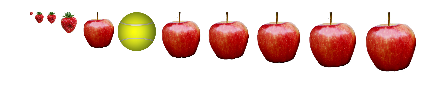

In [8]:
norm_y3 = NormalDistribution(mu=0.3, sigma=0.1)
norm_y4 = NormalDistribution(mu=1.2, sigma=0.25)

p_y3 = 0.4
p_y4 = 0.6

n_samples = 10

x = np.hstack((norm_y3.sample(int(p_y3*n_samples)), norm_y4.sample(int(p_y4*n_samples))))
y = np.hstack((['strawberry']*int(p_y3*n_samples), ['apple']*int(p_y4*n_samples)))

draw_in_row(y, x)

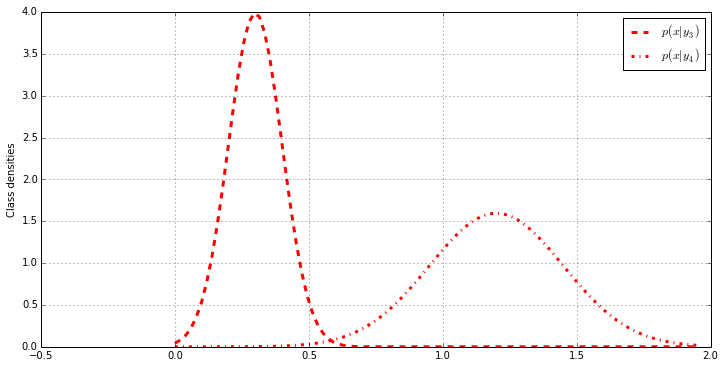

In [9]:
x_min = np.min([norm_y3.mu-3*norm_y3.sigma, norm_y4.mu-3*norm_y4.sigma])
x_max = np.max([norm_y3.mu+3*norm_y3.sigma, norm_y4.mu+3*norm_y4.sigma])

x_lin = np.linspace(x_min, x_max, 100)

p_x_g_y3 = norm_y3.pdf(x_lin)
p_x_g_y4 = norm_y4.pdf(x_lin)


plt.plot(x_lin, p_x_g_y3, '--', color='red', label='$p(x|y_3)$', linewidth=3)
plt.plot(x_lin, p_x_g_y4, '-.', color='red', label='$p(x|y_4)$', linewidth=3)

plt.ylabel('Class densities')
plt.grid(True)
plt.legend()

Because we are not interested in their specific class but we want to consider them as a _background_ class, we will
merge both classes in a mixure of gaussians.
Now we can visualize a sample for both _foreground_ and _background and their corresponding probability density functions.

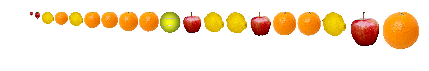

In [10]:
norm_yb = MixtureGaussians([norm_y3, norm_y4], [p_y3, p_y4])

p_y3 = 0.4
p_y4 = 0.6
p_yb = 0.3
p_yf = 1-p_yb

n_samples = 20

x = np.hstack((norm_y1.sample(int(p_yf*p_y1*n_samples)), norm_y2.sample(int(p_yf*p_y2*n_samples)),
               norm_y3.sample(int(p_yb*p_y3*n_samples)), norm_y4.sample(int(p_yb*p_y4*n_samples))
              ))

y = np.hstack((['lemon']*int(p_yf*p_y1*n_samples), ['orange']*int(p_yf*p_y2*n_samples),
               ['strawberry']*int(p_yb*p_y3*n_samples), ['apple']*int(p_yb*p_y4*n_samples)))

draw_in_row(y, x)

y[np.logical_and(y != 'lemon', y != 'orange')] = 'other'

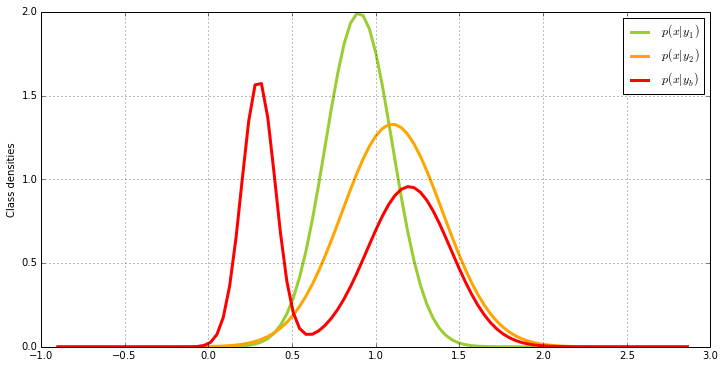

In [11]:
x_lin = np.linspace(x.min()-3*x.std(), x.max()+3*x.std(), 100)

p_x_g_yb = norm_yb.pdf(x_lin)

p_x_g_y1 = norm_y1.pdf(x_lin)
p_x_g_y2 = norm_y2.pdf(x_lin)

plt.plot(x_lin, p_x_g_y1, color='yellowgreen', label='$p(x|y_1)$', linewidth=3)
plt.plot(x_lin, p_x_g_y2, color='orange', label='$p(x|y_2)$', linewidth=3)

plt.plot(x_lin, p_x_g_yb, color='red', label='$p(x|y_b)$', linewidth=3)
plt.ylabel('Class densities')
plt.grid(True)
plt.legend()

## Error during deployment

If we keep the previous optimal bayes solution we can see what would be the error when this _background_ appears. Lets generate a larger sample and measure its performance.

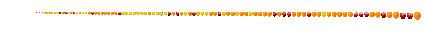

In [12]:
n_samples = 100

x = np.hstack((norm_y1.sample(int(p_yf*p_y1*n_samples)), norm_y2.sample(int(p_yf*p_y2*n_samples)),
               norm_y3.sample(int(p_yb*p_y3*n_samples)), norm_y4.sample(int(p_yb*p_y4*n_samples))
              ))

y = np.hstack((['lemon']*int(p_yf*p_y1*n_samples), ['orange']*int(p_yf*p_y2*n_samples),
               ['strawberry']*int(p_yb*p_y3*n_samples), ['apple']*int(p_yb*p_y4*n_samples)))

draw_in_row(y, x)

y[np.logical_and(y != 'lemon', y != 'orange')] = 'other'

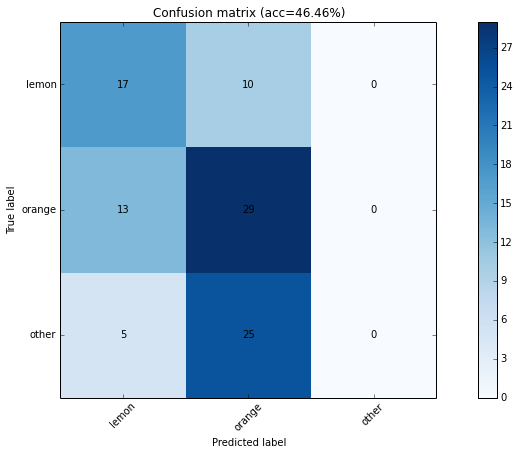

In [13]:
q_x_g_y1 = norm_y1.pdf(x)
q_x_g_y2 = norm_y2.pdf(x)
q_x = q_x_g_y1*p_y1 + q_x_g_y2*p_y2

q_y1_g_x = q_x_g_y1*p_y1/q_x
q_y2_g_x = q_x_g_y2*p_y2/q_x

q_y_g_x = np.vstack((q_y1_g_x, q_y2_g_x))
labels = np.array(['lemon', 'orange', 'other'])
y_pred = labels[q_y_g_x.argmax(axis=0)]

cm = confusion_matrix(y, y_pred, labels=labels)
plot_confusion_matrix(cm, labels=labels)

As we can see in the confusion matrix, it was impossible to predict as other classes. But in this case, this error is not intrinsic from the variance of the known classes, its reason is partially because we were not considering the possibility of getting new classes during deployment time.

What would happend if we consider the existense of the _background_ as a known class? Then we can compute the Optimal bayes considering the k+1 classes, where $\{1,\dots ,k\}$ are the _foreground_ classes and $\{k+1\}$ are all the unknown classes joint into the _background_ class.

### Posterior probabilities considering the real background

Now we consider the background class as the mixture of all possible classes that are not known
during the training. In this case, we merge the strawberries and the apples in the same
bag and we call it background.

$$
    P(Y_b|x) = \frac{P(x|y_b)*P(y_b)}{P(x)}
$$

$$
    P(Y_l|x) = \frac{P(x|y_l)*P(y_l)*P(y_f)}{P(x)}
$$

where now we add the _background_ class

$$
    p(x) = p(x,b) + p(x,f) = p(x|y_b)*P(y_b) + \sum_kp(x|y_k)p(y_k)
$$

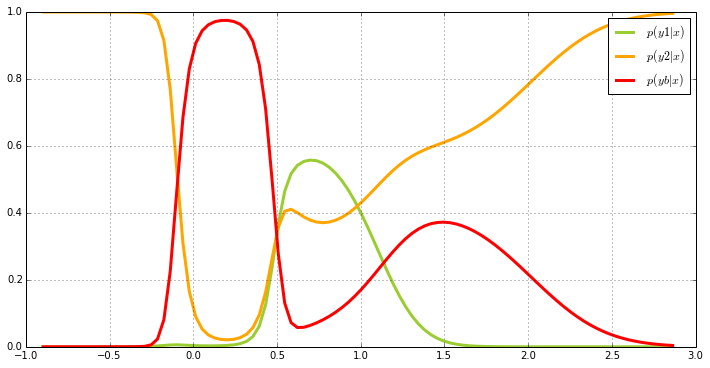

In [14]:
p_x = (p_x_g_y1*p_y1 + p_x_g_y2*p_y2)*p_yf + p_x_g_yb*p_yb

p_y1_g_x = p_x_g_y1*p_y1*p_yf/p_x
p_y2_g_x = p_x_g_y2*p_y2*p_yf/p_x
p_yb_g_x = p_x_g_yb*p_yb/p_x

plt.plot(x_lin, p_y1_g_x, color='yellowgreen', label='$p(y1|x)$', linewidth=3)
plt.plot(x_lin, p_y2_g_x, color='orange', label='$p(y2|x)$', linewidth=3)
plt.plot(x_lin, p_yb_g_x, color='red', label='$p(yb|x)$', linewidth=3)
plt.ylim([0,1])
plt.grid(True)
plt.legend()

These posterior probabilities are now the optimal to minimize the log-loss and accuracy errors.

## Error on test set considering the real background

We can now evaluate the previous generated samples with the new posterior probabilities that allow the model to predict the _background_ class.

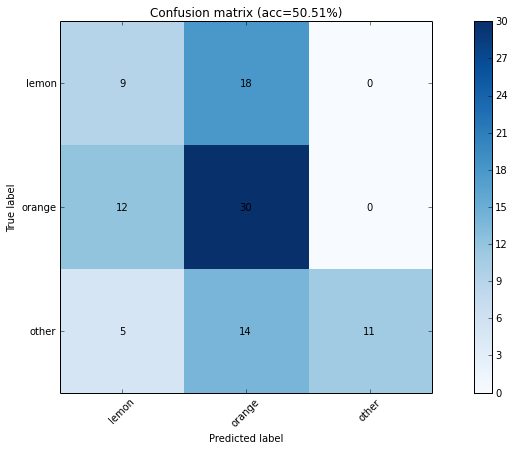

In [15]:
q_x_g_y1 = norm_y1.pdf(x)
q_x_g_y2 = norm_y2.pdf(x)
q_x_g_yb = norm_yb.pdf(x)
q_x = (q_x_g_y1*p_y1 + q_x_g_y2*p_y2)*(1-p_yb) + q_x_g_yb*p_yb

q_y1_g_x = q_x_g_y1*p_y1*p_yf/q_x
q_y2o_g_x = q_x_g_y2*p_y2*p_yf/q_x
q_yb_g_x = q_x_g_yb*p_yb/q_x

q_y_g_x = np.vstack((q_y1_g_x, q_y2_g_x, q_yb_g_x))
labels = np.array(['lemon', 'orange', 'other'])
y_pred = labels[q_y_g_x.argmax(axis=0)]

cm = confusion_matrix(y, y_pred, labels=labels)
plot_confusion_matrix(cm, labels=labels)

We see that the error should be decreased as we are considering the new scenario with _background_ classes.

## How to estimate the background during training?

The previous example is just a theoretical justification that the background needs to be considered. However, how do we estimate a possible background distribution without having the samples?
This is explained in the next tutorials.